## Pentile to RGB Regression

### Samples

In [15]:
import numpy as np
from datetime import datetime
import time
import optuna
import os
import joblib
import matplotlib.pyplot as plt
import csv
from optuna.visualization.matplotlib import plot_optimization_history, plot_pareto_front
from optuna.samplers import TPESampler
from optuna.pruners import MedianPruner

samples = [
    ((24, 56, 57, 55), (0, 56, 56)), ((11, 31, 33, 32), (0, 32, 32)),
    ((28, 1, 31, 1), (32, 0, 32)), ((42, 3, 47, 3), (48, 0, 48)),
    ((65, 7, 72, 7), (72, 0, 72)), ((72, 72, 17, 72), (72, 72, 0)),
    ((56, 56, 11, 56), (56, 56, 0)), ((24, 24, 2, 24), (24, 24, 0)),
    ((214, 213, 73, 214), (216, 216, 0)), ((245, 244, 85, 244), (248, 248, 0)),
    ((137, 244, 246, 244), (0, 248, 248)), ((123, 221, 223, 221), (0, 224, 224)),
    ((99, 182, 181, 181), (0, 184, 184)), ((67, 128, 130, 129),(0, 128, 128)),
    ((29, 63, 65, 64), (0, 64, 64)), ((199, 46, 217, 47),(224, 0, 224)),
    ((130, 26, 141, 26),(144, 0, 144)),((58, 5, 64, 6),(64, 0, 64)),
    ((229, 230, 80, 230),(232, 232, 0)),((150, 150, 48, 150),(152, 152, 0)),
    ((96, 96, 27, 96),(96 ,96 ,0)),
    ((74, 63, 66, 62), (77, 62, 66)), ((89, 143, 92, 142), (49, 149, 90)), 
    ((108, 109, 206, 109), (97, 103, 219)), ((77, 96, 116, 95), (77, 96, 116)),
    ((56, 77, 186, 76), (30, 73, 198)), ((201, 127, 62, 128), (230, 120, 40)),
    ((209, 53, 80, 54), (239, 19, 70)), ((165, 37, 70, 38), (193, 0, 64)),
    ((67, 131, 121, 132), (0, 131, 117)), ((130, 150, 47, 149), (121, 153, 0)),
    ((128, 234, 135, 233), (0, 240, 118)), ((139, 219, 169, 218), (87, 223, 160)),
    ((241, 239, 116, 238), (245, 240, 113)), ((216, 70, 82, 69), (248, 53, 71)),
    ((169, 35, 70, 36), (193, 0, 64)), ((213, 162, 77, 161), (230, 160, 50)),
    ((241, 205, 96, 204), (255, 105, 64)), ((130, 134, 246, 135), (120, 130, 255)),
    ((81, 147, 194, 146), (11, 147, 197)), ((96, 136, 236, 135), (66, 134, 244)),
    ((82, 153, 97, 154), (15, 157, 88)), ((85, 157, 103, 158), (22, 160, 93))
]

CHECKPOINT_PATH = f"spr_study_{datetime.now().strftime('%Y%m%d_%H%M%S')}.pkl"
RESULTS_CSV = "best_params.csv"
PLOT_PATH = "optimization_history.png"
PARETO_PATH = "pareto_front.png"

### Pentile to RGB funcs

In [5]:
def pentile_to_rgb(R, G1, B, G2, params):
    low_bound, mid_bound, close_threshold, enhance_coeffs, reduce_coeffs, thresholds, \
    R_params, G_params, B_params = params
    G = (G1 + G2) >> 1
    R_prime, G_prime, B_prime = R, G, B
    values = [R, G, B]
    sorted_vals = sorted(values, reverse=True)
    max_val, second_val, _ = sorted_vals
    idx = np.argsort(values)[::-1]

    if max_val - second_val < close_threshold:
        if max_val <= low_bound:
            enhance_coeff, reduce_coeff = enhance_coeffs[0], reduce_coeffs[0]
        elif max_val <= mid_bound:
            enhance_coeff, reduce_coeff = enhance_coeffs[1], reduce_coeffs[1]
        else:
            enhance_coeff, reduce_coeff = enhance_coeffs[2], reduce_coeffs[2]

        if (idx[0], idx[1]) in [(0,1), (1,0)]:
            R_prime = min(R + int(enhance_coeff * R), 255)
            G_prime = min(G + int(enhance_coeff * G), 255)
            B_prime = max(B - int(reduce_coeff * (max(R, G) - B)), 0)
        elif (idx[0], idx[1]) in [(0,2), (2,0)]:
            R_prime = min(R + int(enhance_coeff * R), 255)
            B_prime = min(B + int(enhance_coeff * B), 255)
            G_prime = max(G - int(reduce_coeff * (max(R, B) - G)), 0)
        elif (idx[0], idx[1]) in [(1,2), (2,1)]:
            G_prime = min(G + int(enhance_coeff * G), 255)
            B_prime = min(B + int(enhance_coeff * B), 255)
            R_prime = max(R - int(reduce_coeff * (max(G, B) - R)), 0)
    else:
        if idx[0] == 0:
            if R < thresholds[0]:
                R_prime = min(R + R_params[0], 255)
                G_prime = max(G - R_params[4]*(R-G), 0)
                B_prime = max(B - R_params[4]*(R-B), 0)
            elif R < thresholds[1]:
                R_prime = min(R + int(R_params[1]*R), 255)
                G_prime = max(G - int(R_params[5]*(R-G)), 0)
                B_prime = max(B - int(R_params[5]*(R-B)), 0)
            elif R < thresholds[2]:
                R_prime = min(R + int(R_params[2]*R), 255)
                G_prime = max(G - int(R_params[6]*(R-G)), 0)
                B_prime = max(B - int(R_params[6]*(R-B)), 0)
            else:
                R_prime = min(R + int(R_params[3]*R), 255)
                G_prime = max(G - int(R_params[7]*(R-G)), 0)
                B_prime = max(B - int(R_params[7]*(R-B)), 0)
        elif idx[0] == 1:
            if G < thresholds[0]:
                G_prime = min(G + G_params[0], 255)
                R_prime = max(R - G_params[4]*(G-R), 0)
                B_prime = max(B - G_params[4]*(G-B), 0)
            elif G < thresholds[1]:
                G_prime = min(G + int(G_params[1]*G), 255)
                R_prime = max(R - int(G_params[5]*(G-R)), 0)
                B_prime = max(B - int(G_params[5]*(G-B)), 0)
            elif G < thresholds[2]:
                G_prime = min(G + int(G_params[2]*G), 255)
                R_prime = max(R - int(G_params[6]*(G-R)), 0)
                B_prime = max(B - int(G_params[6]*(G-B)), 0)
            else:
                G_prime = min(G + int(G_params[3]*G), 255)
                R_prime = max(R - int(G_params[7]*(G-R)), 0)
                B_prime = max(B - int(G_params[7]*(G-B)), 0)
        else:
            if B < thresholds[0]:
                B_prime = min(B + B_params[0], 255)
                R_prime = max(R - B_params[4]*(B-R), 0)
                G_prime = max(G - B_params[4]*(B-G), 0)
            elif B < thresholds[1]:
                B_prime = min(B + int(B_params[1]*B), 255)
                R_prime = max(R - int(B_params[5]*(B-R)), 0)
                G_prime = max(G - int(B_params[5]*(B-G)), 0)
            elif B < thresholds[2]:
                B_prime = min(B + int(B_params[2]*B), 255)
                R_prime = max(R - int(B_params[6]*(B-R)), 0)
                G_prime = max(G - int(B_params[6]*(B-G)), 0)
            else:
                B_prime = min(B + int(B_params[3]*B), 255)
                R_prime = max(R - int(B_params[7]*(B-R)), 0)
                G_prime = max(G - int(B_params[7]*(B-G)), 0)

    return R_prime, G_prime, B_prime

### 计算MAE和smoothness

In [6]:
def compute_mae_and_smoothness(params):
    total_mae = 0
    smoothness_score = 0
    weighted_mae = 0
    errors = []
    for i, ((R, G1, B, G2), (R_target, G_target, B_target)) in enumerate(samples):
        R_pred, G_pred, B_pred = pentile_to_rgb(R, G1, B, G2, params)
        r_err = abs(R_pred - R_target)
        g_err = abs(G_pred - G_target)
        b_err = abs(B_pred - B_target)
        mae = r_err + g_err + b_err
        errors.append((r_err * 0.5 + g_err * 0.3 + b_err * 0.2))
        smooth = -abs(R_pred - G_pred) - abs(G_pred - B_pred) - abs(B_pred - R_pred)
        total_mae += mae
        smoothness_score += smooth
    n = len(samples)
    max_error = max(errors)
    weights = [np.exp(e / max_error) for e in errors]

    for i, weight in enumerate(weights):
        weighted_mae += errors[i] * weight

    return weighted_mae / n, -smoothness_score / n


def print_predictions(best_params):
    thresholds = [
        best_params["threshold0"],
        best_params["threshold1"],
        best_params["threshold2"]
    ]
    enhance_coeffs = [best_params[f"enhance{i}"] for i in range(3)]
    reduce_coeffs = [best_params[f"reduce{i}"] for i in range(3)]
    R_params = [1] + [best_params[f"R_enh{i+1}"] for i in range(3)] + [best_params[f"R_red{i+1}"] for i in range(4)]
    G_params = [1] + [best_params[f"G_enh{i+1}"] for i in range(3)] + [best_params[f"G_red{i+1}"] for i in range(4)]
    B_params = [1] + [best_params[f"B_enh{i+1}"] for i in range(3)] + [best_params[f"B_red{i+1}"] for i in range(4)]
    params = (
        best_params["low_bound"],
        best_params["mid_bound"],
        best_params["close_threshold"],
        enhance_coeffs,
        reduce_coeffs,
        thresholds,
        tuple(R_params), tuple(G_params), tuple(B_params)
    )
    print("\nSample predictions:")
    for i, ((R, G1, B, G2), (RT, GT, BT)) in enumerate(samples):
        R_pred, G_pred, B_pred = pentile_to_rgb(R, G1, B, G2, params)
        print(f"Sample {i+1}: Predicted = ({R_pred}, {G_pred}, {B_pred}), Target = ({RT}, {GT}, {BT}), Δ = ({abs(R_pred - RT)}, {abs(G_pred - GT)}, {abs(B_pred - BT)})")


### 优化目标函数

In [7]:
    # ✅ 定义完整的优化目标函数，包括 thresholds
def objective(trial):
    threshold0 = trial.suggest_int("threshold0", 5, 100)
    threshold1 = trial.suggest_int("threshold1", threshold0 + 1, 200)
    threshold2 = trial.suggest_int("threshold2", threshold1 + 1, 255)

    low_bound = trial.suggest_int("low_bound", 40, 150)
    mid_bound = trial.suggest_int("mid_bound", low_bound + 1, 255)
    close_threshold = trial.suggest_int("close_threshold", 1, 10)

    enhance_coeffs = [
        trial.suggest_float("enhance0", 0.01, 0.05),
        trial.suggest_float("enhance1", 0.05, 0.1),
        trial.suggest_float("enhance2", 0.1, 0.2)
    ]
    reduce_coeffs = [
        trial.suggest_float("reduce0", 0.1, 0.3),
        trial.suggest_float("reduce1", 0.3, 0.5),
        trial.suggest_float("reduce2", 0.5, 0.8)
    ]

    thresholds = [threshold0, threshold1, threshold2]

    R_params = [
        1,
        trial.suggest_float("R_enh1", 0.02, 0.08),
        trial.suggest_float("R_enh2", 0.07, 0.13),
        trial.suggest_float("R_enh3", 0.05, 0.11),
        trial.suggest_float("R_red1", 0.01, 0.06),
        trial.suggest_float("R_red2", 0.05, 0.11),
        trial.suggest_float("R_red3", 0.12, 0.18),
        trial.suggest_float("R_red4", 0.22, 0.28)
    ]

    G_params = [
        1,
        trial.suggest_float("G_enh1", 0.01, 0.08),
        trial.suggest_float("G_enh2", 0.05, 0.1),
        trial.suggest_float("G_enh3", 0.06, 0.11),
        trial.suggest_float("G_red1", 0.22, 0.28),
        trial.suggest_float("G_red2", 0.42, 0.48),
        trial.suggest_float("G_red3", 0.52, 0.58),
        trial.suggest_float("G_red4", 0.78, 0.83)
    ]

    B_params = [
        1,
        trial.suggest_float("B_enh1", 0.02, 0.08),
        trial.suggest_float("B_enh2", 0.06, 0.12),
        trial.suggest_float("B_enh3", 0.01, 0.06),
        trial.suggest_float("B_red1", 0.01, 0.06),
        trial.suggest_float("B_red2", 0.08, 0.13),
        trial.suggest_float("B_red3", 0.12, 0.18),
        trial.suggest_float("B_red4", 0.02, 0.08)
    ]

    params = (
        low_bound, mid_bound, close_threshold,
        enhance_coeffs, reduce_coeffs, thresholds,
        tuple(R_params), tuple(G_params), tuple(B_params)
    )
    return compute_mae_and_smoothness(params)

### Main()

100%|█████████▉| 998/1000 [07:00<00:01,  1.95it/s]

[I 2025-04-02 05:04:12,122] Trial 997 finished with values: [24.931374289155887, 235.18339987938106] and parameters: {'threshold0': 49, 'threshold1': 185, 'threshold2': 241, 'low_bound': 142, 'mid_bound': 247, 'close_threshold': 1, 'enhance0': 0.010815761233745906, 'enhance1': 0.05924818040404002, 'enhance2': 0.14693436133050622, 'reduce0': 0.15391650726345146, 'reduce1': 0.36785343458835407, 'reduce2': 0.5342189537955294, 'R_enh1': 0.05313055824586567, 'R_enh2': 0.07206990054661709, 'R_enh3': 0.05427415158017104, 'R_red1': 0.013405838635973052, 'R_red2': 0.05086020535418494, 'R_red3': 0.161370551089879, 'R_red4': 0.2545694419215541, 'G_enh1': 0.014052985990785125, 'G_enh2': 0.06474674894304465, 'G_enh3': 0.09053742157088428, 'G_red1': 0.2753391052744834, 'G_red2': 0.4436217284568876, 'G_red3': 0.5461224622820373, 'G_red4': 0.7950528354438556, 'B_enh1': 0.02135990383313736, 'B_enh2': 0.06939345219682161, 'B_enh3': 0.045759297906583334, 'B_red1': 0.02544893131971099, 'B_red2': 0.1067369

100%|██████████| 1000/1000 [07:01<00:00,  2.37it/s]


[I 2025-04-02 05:04:12,340] Trial 998 finished with values: [25.739021031562928, 242.0387630127152] and parameters: {'threshold0': 42, 'threshold1': 65, 'threshold2': 254, 'low_bound': 142, 'mid_bound': 247, 'close_threshold': 1, 'enhance0': 0.010851981048379077, 'enhance1': 0.05559543207943451, 'enhance2': 0.17673092632840678, 'reduce0': 0.16270320344863085, 'reduce1': 0.38054088154339244, 'reduce2': 0.5081397809640105, 'R_enh1': 0.07028750189121633, 'R_enh2': 0.07060980083945309, 'R_enh3': 0.057756807254201445, 'R_red1': 0.010116475003544165, 'R_red2': 0.05882503248564383, 'R_red3': 0.15442774552326624, 'R_red4': 0.24473822737604428, 'G_enh1': 0.04113510275450753, 'G_enh2': 0.07397928349640823, 'G_enh3': 0.09261828226795515, 'G_red1': 0.2530925852041284, 'G_red2': 0.43699308268385895, 'G_red3': 0.5295215005271813, 'G_red4': 0.7884926519400967, 'B_enh1': 0.025936592230758632, 'B_enh2': 0.09208251038129604, 'B_enh3': 0.03927230897624308, 'B_red1': 0.03788203515348107, 'B_red2': 0.11493

C:\Users\User\AppData\Local\Temp\ipykernel_5940\3373255647.py:31: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  fig_ax = plot_optimization_history(study, target=lambda t: t.values[0], target_name="MAE")



Best Trial:
  MAE: 21.642757073525036
  Smoothness: 254.74812913881954
  Parameters:
    threshold0: 77
    threshold1: 95
    threshold2: 111
    low_bound: 126
    mid_bound: 236
    close_threshold: 3
    enhance0: 0.02534091591233719
    enhance1: 0.05123812538392141
    enhance2: 0.14097182278232065
    reduce0: 0.11695116439738287
    reduce1: 0.4676364838192943
    reduce2: 0.7932112588097777
    R_enh1: 0.051792787312257296
    R_enh2: 0.07978235360528446
    R_enh3: 0.10398007147006103
    R_red1: 0.019355126302693444
    R_red2: 0.1037606932563462
    R_red3: 0.1746587154005528
    R_red4: 0.22877019485878258
    G_enh1: 0.032136780124919447
    G_enh2: 0.06999517141757253
    G_enh3: 0.06710657598680386
    G_red1: 0.24830473460419
    G_red2: 0.46542257585945773
    G_red3: 0.5614580438198105
    G_red4: 0.8021004117444857
    B_enh1: 0.03184584747355473
    B_enh2: 0.10124633397868754
    B_enh3: 0.021602595896382845
    B_red1: 0.034836398624934435
    B_red2: 0.10049763

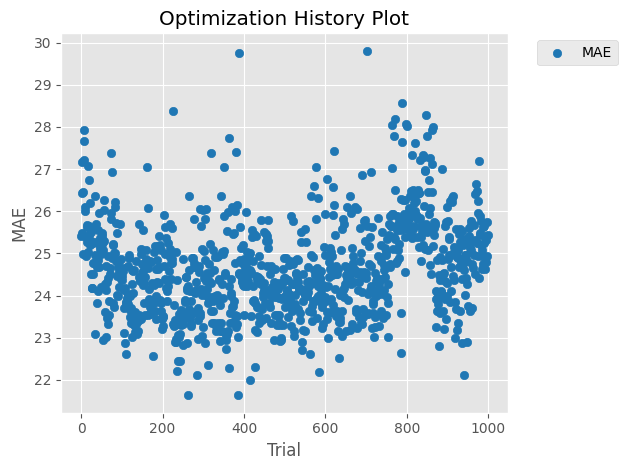

In [28]:
if __name__ == '__main__':
    start_time = time.time()

    if os.path.exists(CHECKPOINT_PATH):
        study = joblib.load(CHECKPOINT_PATH)
        print("✅ 恢复已有优化状态。")
    else:
        sampler = TPESampler(multivariate=True, warn_independent_sampling=False)
        pruner = MedianPruner(n_warmup_steps=50)
        study = optuna.create_study(
        directions=["minimize", "minimize"],
            sampler=sampler,
            pruner=pruner
        )

    study.optimize(objective, n_trials=1000, n_jobs=-1, show_progress_bar=True)
    joblib.dump(study, CHECKPOINT_PATH)

    # 自动筛选平衡解（最小化 MAE 和 Smoothness 乘积）
    best_trial = min(
        study.best_trials,
        key=lambda t: t.values[0] * abs(t.values[1])  # 平衡误差与平滑
    )

    with open(RESULTS_CSV, mode='w', newline='') as f:
        writer = csv.writer(f)
        writer.writerow(["parameter", "value"])
        for k, v in best_trial.params.items():
            writer.writerow([k, v])

    fig_ax = plot_optimization_history(study, target=lambda t: t.values[0], target_name="MAE")
    fig_ax.figure.tight_layout()
    fig_ax.figure.savefig(PLOT_PATH)

    # pareto_ax = plot_pareto_front(study, target_names=["MAE", "Smoothness"])
    # pareto_ax.figure.tight_layout()
    # pareto_ax.figure.savefig(PARETO_PATH)

    print("\nBest Trial:")
    print("  MAE:", best_trial.values[0])
    print("  Smoothness:", best_trial.values[1])
    print("  Parameters:")
    for k, v in best_trial.params.items():
        print(f"    {k}: {v}")

    print_predictions(best_trial.params)

    print(f"\n总耗时: {time.time() - start_time:.2f} 秒")
    print(f"最优参数已保存到 {RESULTS_CSV}")
    print(f"优化过程图像已保存为 {PLOT_PATH}")
    print(f"Pareto 前沿图已保存为 {PARETO_PATH}")

### 误差分析

In [14]:
def load_params_from_csv(csv_path):
    import csv
    best_params = {}
    with open(csv_path, mode='r') as f:
        reader = csv.reader(f)
        next(reader)  # 跳过标题行
        for row in reader:
            key, value = row
            try:
                best_params[key] = int(value)
            except ValueError:
                best_params[key] = float(value)
    return best_params


def print_top_errors_from_csv(csv_path, top_k=5):
    best_params = load_params_from_csv(csv_path)

    thresholds = [
        best_params["threshold0"],
        best_params["threshold1"],
        best_params["threshold2"]
    ]
    enhance_coeffs = [best_params[f"enhance{i}"] for i in range(3)]
    reduce_coeffs = [best_params[f"reduce{i}"] for i in range(3)]
    R_params = [1] + [best_params[f"R_enh{i+1}"] for i in range(3)] + [best_params[f"R_red{i+1}"] for i in range(4)]
    G_params = [1] + [best_params[f"G_enh{i+1}"] for i in range(3)] + [best_params[f"G_red{i+1}"] for i in range(4)]
    B_params = [1] + [best_params[f"B_enh{i+1}"] for i in range(3)] + [best_params[f"B_red{i+1}"] for i in range(4)]
    params = (
        best_params["low_bound"],
        best_params["mid_bound"],
        best_params["close_threshold"],
        enhance_coeffs,
        reduce_coeffs,
        thresholds,
        tuple(R_params), tuple(G_params), tuple(B_params)
    )

    error_list = []
    for i, ((R, G1, B, G2), (RT, GT, BT)) in enumerate(samples):
        R_pred, G_pred, B_pred = pentile_to_rgb(R, G1, B, G2, params)
        r_err = abs(R_pred - RT)
        g_err = abs(G_pred - GT)
        b_err = abs(B_pred - BT)
        weighted_err = r_err * 0.5 + g_err * 0.3 + b_err * 0.2
        error_list.append((weighted_err, i, (R, G1, B, G2), (R_pred, G_pred, B_pred), (RT, GT, BT)))

    error_list.sort(reverse=True)
    print(f"\nTop {top_k} Worst Errors:")
    for err, idx, inp, pred, tgt in error_list[:top_k]:
        print(f"Sample {idx+1}: Input={inp}, Pred={pred}, Target={tgt}, Weighted Error={err:.2f}")

    
print("\n---误差分析---")
print_top_errors_from_csv('params/best_params_20250402_193200.csv', top_k=10)





---误差分析---

Top 10 Worst Errors:
Sample 12: Input=(123, 221, 223, 221), Pred=(79, 233, 235), Target=(0, 224, 224), Weighted Error=44.40
Sample 21: Input=(96, 27, 96, 96), Pred=(101, 46, 101), Target=(96, 96, 0), Weighted Error=37.70
Sample 32: Input=(128, 234, 135, 233), Pred=(43, 249, 56), Target=(0, 240, 118), Weighted Error=36.60
Sample 13: Input=(99, 182, 181, 181), Pred=(63, 191, 191), Target=(0, 184, 184), Weighted Error=35.00
Sample 11: Input=(137, 244, 246, 244), Pred=(61, 255, 255), Target=(0, 248, 248), Weighted Error=34.00
Sample 40: Input=(81, 147, 194, 146), Pred=(71, 142, 202), Target=(11, 147, 197), Weighted Error=32.50
Sample 38: Input=(241, 205, 96, 204), Pred=(255, 196, 62), Target=(255, 105, 64), Weighted Error=27.70
Sample 14: Input=(67, 128, 130, 129), Pred=(39, 135, 137), Target=(0, 128, 128), Weighted Error=23.40
Sample 16: Input=(199, 46, 217, 47), Pred=(197, 18, 236), Target=(224, 0, 224), Weighted Error=21.30
Sample 42: Input=(82, 153, 97, 154), Pred=(50, 158